# Galaxy Zoo - The Galaxy Challenge

In [1]:
# 使うGPUを指定
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="9"
# os.environ["CUDA_VISIBLE_DEVICES"]="6"
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

# tensorflowは普通に使用すると、GPUメモリを取れるだけとってしまうため、最小限だけ使うように設定する。
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.__version__

'2.3.1'

In [2]:
# !echo $CUDA_VISIBLE_DEVICES

In [3]:
!pip install pandas pillow matplotlib scikit-learn scikit-image

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('../input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [5]:
from tqdm import tqdm
import zipfile
import io
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras import backend as K

In [7]:
pd.options.display.max_columns = 999
df = pd.read_csv('../input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027227,0.000000,0.027227,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [8]:
df.describe()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
count,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000
mean,550179.708337,0.432526,0.542261,0.025213,0.106408,0.435854,0.102526,0.333328,0.215629,0.220224,0.040842,0.180468,0.177904,0.036639,0.231807,0.768193,0.170021,0.207765,0.054740,0.034812,0.013449,0.032807,0.040044,0.064546,0.042307,0.003842,0.063014,0.010614,0.032780,0.091801,0.083969,0.039859,0.015411,0.094338,0.017587,0.007603,0.007006,0.073683
std,258724.130197,0.283517,0.296429,0.037967,0.212505,0.301867,0.177301,0.247675,0.285502,0.179835,0.087419,0.192508,0.180277,0.060300,0.227393,0.227393,0.238860,0.215967,0.110445,0.101319,0.027435,0.051930,0.081152,0.090286,0.108537,0.024408,0.137545,0.038236,0.098200,0.145125,0.139840,0.099657,0.052285,0.193920,0.067476,0.037678,0.037280,0.107454
min,100008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,327874.250000,0.175812,0.280862,0.000000,0.000000,0.168490,0.000000,0.122592,0.000000,0.072656,0.000000,0.000000,0.000000,0.000000,0.066087,0.673057,0.000000,0.032554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,551933.000000,0.416994,0.558754,0.014870,0.000000,0.394850,0.000000,0.289248,0.092987,0.183640,0.000000,0.116580,0.126765,0.000000,0.149545,0.850455,0.035954,0.125757,0.000000,0.000000,0.000000,0.000000,0.000000,0.034163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,773232.000000,0.679182,0.811339,0.034325,0.085161,0.694615,0.134555,0.516800,0.330231,0.338920,0.044376,0.290133,0.284554,0.057294,0.326943,0.933913,0.280679,0.333788,0.049136,0.027767,0.025160,0.046129,0.044907,0.086541,0.032199,0.000000,0.056038,0.000000,0.000000,0.147239,0.127381,0.030621,0.000000,0.098670,0.000000,0.000000,0.000000,0.128798
max,999967.000000,1.000000,1.000000,0.935147,1.000000,1.000000,1.000000,1.000000,1.000000,0.957937,0.803556,0.965112,0.891034,0.650383,1.000000,1.000000,1.000000,1.000000,0.883481,0.969157,0.807733,0.598390,0.860000,0.790470,0.971000,0.719088,0.985982,0.889493,0.901991,0.949733,0.877393,0.996952,0.886363,1.000000,0.975913,0.957000,0.938881,0.753082


In [9]:
# df = df.sample(n=1000, random_state=0)

In [10]:
DATA_DIR = '../input/galaxy-zoo-the-galaxy-challenge/'
zippath = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip'
ORIG_SIZE = 424
# IMG_SIZE = 224
IMG_SIZE = 299
# IMG_SIZE = 424

batch_size = 32
# batch_size = 16

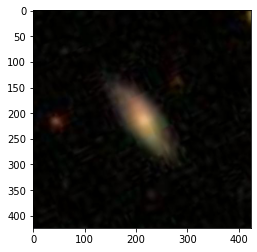

In [11]:
# load zip
zippath = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip'
z = zipfile.ZipFile(zippath)

# load image from zip
# imgname = 'images_training_rev1/100008.jpg'
imgname = 'images_training_rev1/100023.jpg'
im = Image.open(io.BytesIO(z.read(imgname)))
im_list = np.asarray(im)
plt.imshow(im_list)
plt.show()

z.close()

In [12]:
im_list.shape

(424, 424, 3)

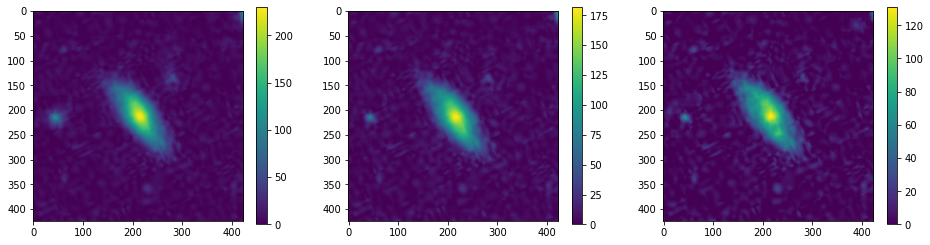

In [13]:
plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(im_list[:,:,i])
    plt.colorbar()
plt.show()

## tf.data.Dataset を使う

In [14]:
def preprocess_image(image, augment_flag=False):
    image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)  # 中央crop
    if augment_flag:
        image = tf.image.random_flip_left_right(image)  # 左右反転
        image = tf.image.random_flip_up_down(image)     # 上下反転
    image /= 255  # normalize to [0,1] range

    return image

In [15]:
def load_and_preprocess_image(path):
    img_path = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1/' + path + '.jpg'
    image = tf.io.read_file(img_path)
    return preprocess_image(image,  augment_flag=True)

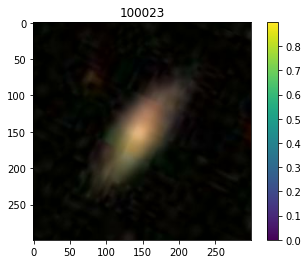

In [16]:
import matplotlib.pyplot as plt

label = str(df.iloc[1, 0])
# label = '303732'
# img_path = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1/' + label + '.jpg'

plt.imshow(load_and_preprocess_image(label))
plt.grid(False)
plt.title(label)
plt.colorbar()
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(df.values[:,0].astype(int).astype(str), df.values[:,1:], test_size=0.2, random_state=0)

In [18]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((49262,), (12316,), (49262, 37), (12316, 37))

In [19]:
path_ds = tf.data.Dataset.from_tensor_slices(x_train)

In [20]:
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [21]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [22]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_train, tf.float32))

In [23]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [24]:
# ds = image_label_ds.cache(filename='./cache.tf-data')
# ds = image_label_ds.cache()
ds = image_label_ds
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=1000))
ds = ds.batch(batch_size)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [25]:
path_ds_valid = tf.data.Dataset.from_tensor_slices(x_test)
image_ds_valid = path_ds_valid.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds_valid = tf.data.Dataset.from_tensor_slices(tf.cast(y_test, tf.float32))
ds_valid = tf.data.Dataset.zip((image_ds_valid, label_ds_valid))
ds_valid = ds_valid.batch(batch_size)

In [26]:
y_test.shape

(12316, 37)

In [27]:
# for x in image_ds:
# for x, y in image_label_ds:
for x, y in ds:
#     print(x.shape)
    print(x.shape, y.shape)
    break

(32, 299, 299, 3) (32, 37)


## Model

In [28]:
# ネットワークの構築
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, MobileNetV2, EfficientNetB0, InceptionResNetV2, Xception
from tensorflow.keras import models, layers, regularizers

# conv_base = VGG16(weights='imagenet',
# conv_base = ResNet50(weights='imagenet',
# conv_base = ResNet50V2(weights='imagenet',
# conv_base = MobileNetV2(weights='imagenet',
# conv_base = EfficientNetB0(weights='imagenet',
# conv_base = InceptionResNetV2(weights='imagenet',
# conv_base = Xception(weights='imagenet',
conv_base = Xception(weights='xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
                 include_top=False, pooling='avg',
                 input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [29]:
conv_base.input_shape

(None, 299, 299, 3)

In [30]:
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027227,0.000000,0.027227,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [31]:
# Functional API
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Multiply
from tensorflow.keras.activations import softmax, sigmoid
from tensorflow.keras import Model

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_base(inputs)
x = Flatten()(x)
x = Dense(37, kernel_initializer='he_normal')(x)

# Galaxy Zoo の Decision Tree の条件をモデルに反映
x01 = softmax(x[:,:3])                             # Task01 合計が1.0
x02 = Multiply()([softmax(x[:, 3: 5]), x01[:,1]])  # Task02 合計がTask01の2つ目
x03 = Multiply()([softmax(x[:, 5: 7]), x02[:,1]])  # Task03 合計がTask02の2つ目
x04 = Multiply()([softmax(x[:, 7: 9]), x02[:,1]])  # Task04 合計がTask02の2つ目
x05 = Multiply()([softmax(x[:, 9:13]), x04[:,1]])  # Task05 合計がTask04の2つ目
x06 = Multiply()([softmax(x[:,13:15]), x04[:,1]])  # Task06 合計がTask04の2つ目
x07 = Multiply()([softmax(x[:,15:18]), x01[:,0]])  # Task07 合計がTask01の1つ目
x08 = Multiply()([softmax(x[:,18:25]), x06[:,0]])  # Task08 合計がTask06の1つ目
x09 = Multiply()([softmax(x[:,25:28]), x02[:,0]])  # Task09 合計がTask02の1つ目
x10 = Multiply()([softmax(x[:,28:31]), x04[:,0]])  # Task10 合計がTask04の1つ目
x11 = Multiply()([softmax(x[:,31:37]), x04[:,0]])  # Task11 合計がTask04の1つ目

outputs = Concatenate(axis=1)([x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11])
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 2048)         20861480    input_2[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2048)         0           xception[0][0]                   
__________________________________________________________________________________________________
dense (Dense)                   (None, 37)           75813       flatten[0][0]                    
_______________________________________________________________________________________

In [32]:
# for layer in conv_base.layers:
#     print(layer.name)

In [33]:
# 凍結
# conv_base.trainable = False

# 最初から特定の層までを凍結
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block11_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

len(model.trainable_weights)

45

In [34]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [35]:
# オプティマイザ構築
from tensorflow.keras import optimizers

model.compile(loss='MeanSquaredError',
#              optimizer=optimizers.RMSprop(lr=1e-4),
#              optimizer=optimizers.RMSprop(lr=1e-3),
#              optimizer=optimizers.Adam(lr=1e-4),
             optimizer=optimizers.Adam(lr=1e-3),
#              optimizer=optimizers.SGD(lr=0.01),
#              optimizer=optimizers.SGD(lr=0.01, momentum=0.9),
             metrics=['acc', root_mean_squared_error])

In [36]:
%%time
# history = model.fit(ds, epochs=5, steps_per_epoch=10, use_multiprocessing=True, workers=8, 
#                     validation_steps=10, validation_data=ds_valid)
history = model.fit(ds, epochs=5, steps_per_epoch=x_train.shape[0]//batch_size, use_multiprocessing=True, workers=8, 
                    validation_steps=x_test.shape[0]//batch_size, validation_data=ds_valid)
# history = model.fit(ds, epochs=20, steps_per_epoch=61578//32+1, workers=0, validation_steps=1, validation_data=ds_valid, initial_epoch=2)

Epoch 1/5
1539/1539 [==============================] - 1917s 1s/step - loss: 0.0210 - acc: 0.3244 - root_mean_squared_error: 0.1446 - val_loss: 0.0204 - val_acc: 0.3313 - val_root_mean_squared_error: 0.1427
Epoch 2/5
1539/1539 [==============================] - 1673s 1s/step - loss: 0.0190 - acc: 0.3300 - root_mean_squared_error: 0.1378 - val_loss: 0.0191 - val_acc: 0.3361 - val_root_mean_squared_error: 0.1380
Epoch 3/5
1539/1539 [==============================] - 1669s 1s/step - loss: 0.0183 - acc: 0.3316 - root_mean_squared_error: 0.1353 - val_loss: 0.0181 - val_acc: 0.3385 - val_root_mean_squared_error: 0.1346
Epoch 4/5
1539/1539 [==============================] - 1683s 1s/step - loss: 0.0179 - acc: 0.3320 - root_mean_squared_error: 0.1338 - val_loss: 0.0182 - val_acc: 0.3368 - val_root_mean_squared_error: 0.1346
Epoch 5/5
1539/1539 [==============================] - 1628s 1s/step - loss: 0.0176 - acc: 0.3326 - root_mean_squared_error: 0.1326 - val_loss: 0.0182 - val_acc: 0.3351 - v

In [37]:
y_pred = model.predict(ds_valid, use_multiprocessing=True, workers=8, verbose=1, steps=1)

1/1 [==============================] - 0s 472ms/step


In [38]:
idx = 2
print(y_pred[idx])
print(sum(y_pred[idx,:3]), sum(y_pred[idx,3:5]), sum(y_pred[idx,5:7]), sum(y_pred[idx,7:9]), sum(y_pred[idx,9:13]), 
      sum(y_pred[idx,13:15]), sum(y_pred[idx,15:18]), sum(y_pred[idx,18:25]), sum(y_pred[idx,25:28]), sum(y_pred[idx,28:31]), 
      sum(y_pred[idx,31:37]))

[2.7720818e-01 3.4371829e-01 3.7907350e-01 2.4082491e-02 3.1963581e-01
 1.0392590e-01 2.1570989e-01 6.8410195e-02 2.5122562e-01 9.9796720e-02
 8.2142718e-02 3.7324738e-02 3.1961448e-02 1.4860567e-01 1.0261993e-01
 1.4718887e-01 1.0609709e-01 2.3922207e-02 1.0335722e-03 3.8786858e-04
 6.6146255e-03 3.3476233e-02 1.0089473e-01 5.8843428e-03 3.1430210e-04
 1.4459145e-02 1.2234017e-03 8.3999438e-03 1.5879553e-02 2.8364640e-02
 2.4166003e-02 6.3991821e-03 2.7703112e-02 2.9397930e-03 2.2359286e-03
 3.0477536e-03 2.6084425e-02]
0.9999999701976776 0.34371829964220524 0.3196357935667038 0.3196358159184456 0.25122562423348427 0.2512256056070328 0.27720816619694233 0.14860567150753923 0.024082490825094283 0.06841019541025162 0.0684101942460984


In [39]:
model.evaluate(ds_valid)

385/385 [==============================] - 231s 601ms/step - loss: 0.0182 - acc: 0.3353 - root_mean_squared_error: 0.1349


[0.018231330439448357, 0.3353361487388611, 0.13489314913749695]

In [40]:
model.save('my_model_Xception_func_trainable11_avg.h5')

In [41]:
history.history

{'loss': [0.020991530269384384,
  0.01901138201355934,
  0.01834341511130333,
  0.017933201044797897,
  0.01761169172823429],
 'acc': [0.3244192600250244,
  0.3299626410007477,
  0.3315667510032654,
  0.3319525718688965,
  0.332561731338501],
 'root_mean_squared_error': [0.14460398256778717,
  0.13775232434272766,
  0.13532646000385284,
  0.13380247354507446,
  0.13260677456855774],
 'val_loss': [0.020420262590050697,
  0.019074952229857445,
  0.018138239160180092,
  0.018158378079533577,
  0.018214864656329155],
 'val_acc': [0.331298828125,
  0.3361002504825592,
  0.3385416567325592,
  0.3367513120174408,
  0.3351236879825592],
 'val_root_mean_squared_error': [0.14274217188358307,
  0.13797228038311005,
  0.13457091152668,
  0.13461391627788544,
  0.1348349153995514]}

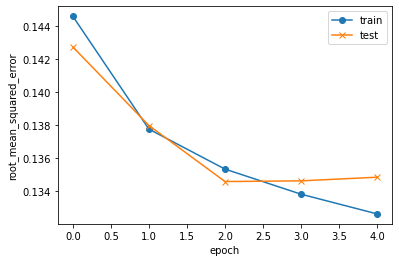

In [42]:
plt.plot(history.history["root_mean_squared_error"], label="train", ls="-", marker="o")
plt.plot(history.history["val_root_mean_squared_error"], label="test", ls="-", marker="x")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

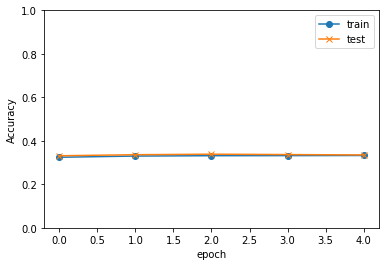

In [43]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="train", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="test", ls="-", marker="x")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

## Submission

In [44]:
submission = pd.read_csv('../input/galaxy-zoo-the-galaxy-challenge/all_ones_benchmark.zip')

In [45]:
# submission = submission.sample(n=1000, random_state=0)

In [46]:
submission.shape

(79975, 38)

In [47]:
def load_and_preprocess_test_image(path):
    img_path = '../input/galaxy-zoo-the-galaxy-challenge/images_test_rev1/' + path + '.jpg'
    image = tf.io.read_file(img_path)
    return preprocess_image(image)

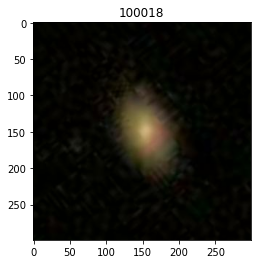

In [48]:
import matplotlib.pyplot as plt

label = str(submission.iloc[0, 0])

plt.imshow(load_and_preprocess_test_image(label))
plt.grid(False)
plt.title(label)
print()

In [49]:
path_ds_test = tf.data.Dataset.from_tensor_slices(submission.values[:,0].astype(int).astype(str))
image_ds_test = path_ds_test.map(load_and_preprocess_test_image, num_parallel_calls=AUTOTUNE)
label_ds_test = tf.data.Dataset.from_tensor_slices(tf.cast(np.zeros((submission.shape[0], 37)), tf.float32))
ds_test = tf.data.Dataset.zip((image_ds_test, label_ds_test))
ds_test = ds_test.batch(batch_size)

In [50]:
# y_pred = model.predict(test_x)
y_pred = model.predict(ds_test, use_multiprocessing=True, workers=8, verbose=1)

2500/2500 [==============================] - 1661s 665ms/step


In [51]:
submission.iloc[:, 1:] = y_pred

In [52]:
submission.to_csv('../output/submission_Xception_func_trainable11_avg.csv', index=False)